## Importing the required libraries

In [85]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import tensorflow.keras
from tensorflow.keras import optimizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [28]:
from keras import regularizers

In [29]:
import os

In [41]:
mylist= os.listdir('RawData/')

In [42]:
type(mylist)

list

In [44]:
print(mylist[100])

03-02-02-01-01-01-09.wav


In [43]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [49]:
data, sampling_rate = librosa.load('RawData/f11 (2).wav')

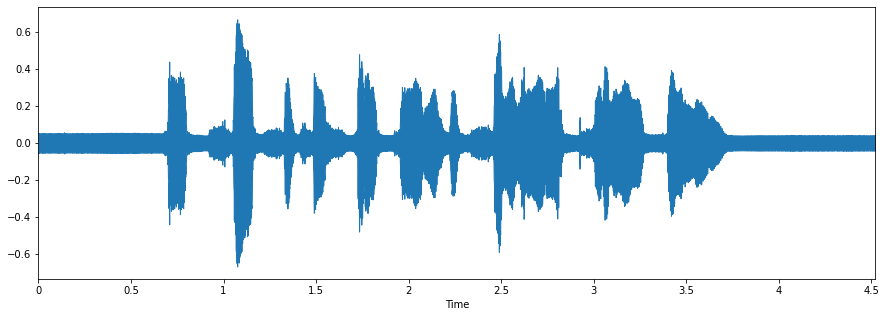

In [50]:

import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

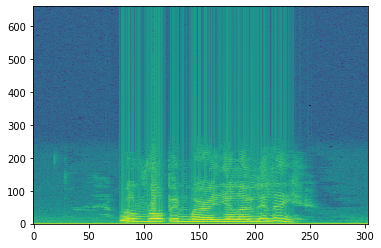

In [51]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [52]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [53]:
labels = pd.DataFrame(feeling_list)

In [54]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [55]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' 
    and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [56]:
df[:5]

,feature
0,"[-61.542942, -61.67029, -61.663513, -61.675594..."
1,"[-59.344055, -59.344055, -59.344055, -59.34405..."
2,"[-48.954494, -48.82861, -49.6816, -52.03216, -..."
3,"[-60.07603, -60.313347, -59.857048, -57.80332,..."
4,"[-60.01485, -62.686897, -65.488106, -60.48127,..."


In [57]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [58]:
newdf = pd.concat([df3,labels], axis=1)

In [59]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [60]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542942,-61.670292,-61.663513,-61.675594,-59.627464,-58.578274,-60.384644,-60.370815,-59.209068,-59.793682,...,-32.029648,-28.536741,-27.502647,-26.418863,-27.831207,-28.752035,-28.786449,-21.615858,-17.308699,male_calm
1,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,...,-42.964802,-43.955097,-44.208012,-43.749870,-42.165371,-43.236347,-43.611912,-20.658556,-12.422130,female_calm
2,-48.954494,-48.828609,-49.681599,-52.032162,-48.399113,-47.975899,-49.650616,-51.260967,-49.758038,-50.975227,...,-23.577650,-24.113667,-22.895826,-22.712572,-24.839592,-27.322344,-28.557560,-28.592690,-25.435741,male_calm
3,-60.076031,-60.313347,-59.857048,-57.803322,-58.947754,-59.264015,-57.992619,-57.401936,-57.059834,-57.166061,...,-42.776798,-40.195335,-38.818478,-39.010696,-41.907330,-42.493778,-43.464279,-36.841316,-29.907368,female_calm
4,-60.014851,-62.686897,-65.488106,-60.481270,-60.038151,-64.788376,-66.386238,-61.152500,-58.949646,-59.597214,...,-43.592575,-42.287838,-42.087948,-42.331047,-40.317867,-37.837944,-35.932858,-32.704998,-28.022449,male_calm


In [61]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
283,-47.381340,-47.508354,-48.549412,-48.080776,-48.921413,-47.577122,-47.597374,-48.469151,-48.599758,-49.150887,...,-47.142471,-44.063046,-37.518440,-38.849648,-39.288498,-40.967911,-42.601032,-23.253811,-13.904069,female_happy
400,-47.167732,-46.421211,-47.138248,-47.365257,-46.334309,-47.972633,-48.121826,-46.813126,-46.731663,-47.031345,...,-36.889614,-36.662239,-38.318478,-39.726479,-40.783062,-39.392902,-38.401089,-20.925903,-12.441305,female_sad
56,-57.126324,-53.556534,-50.223091,-51.541733,-51.580605,-51.579018,-55.051968,-54.398800,-46.765240,-42.528648,...,-29.545340,-31.429478,-32.014114,-32.087639,-28.786581,-26.376902,-25.080210,-22.571651,-17.432291,male_calm
892,-44.077454,-44.120255,-44.044144,-43.886639,-43.938400,-43.982857,-43.978279,-43.917618,-43.877693,-43.932278,...,-37.851116,-37.273048,-36.025757,-36.744209,-36.098927,-36.917439,-36.604408,-9.535180,-1.409991,female_fearful
425,-55.576317,-55.576317,-55.576317,-54.659672,-54.034431,-54.494568,-54.857063,-54.399475,-53.959286,-53.900295,...,-39.122200,-36.716236,-40.453377,-40.219475,-41.346844,-42.880005,-44.229630,-27.269268,-20.113741,female_sad
232,-53.414528,-53.414528,-53.414528,-53.414528,-53.414528,-53.414528,-53.414528,-53.414528,-53.414528,-53.414528,...,-17.525341,-20.309048,-21.865204,-22.352537,-22.352446,-22.234642,-22.342314,-18.170515,-13.280735,male_happy
426,-67.041275,-67.041275,-67.041275,-66.402695,-66.893990,-64.819160,-64.593857,-64.499008,-64.641861,-64.856880,...,-33.569321,-32.266354,-32.128036,-32.194382,-32.837791,-34.368618,-35.203636,-32.419277,-27.889662,male_sad
296,-49.494350,-49.494350,-49.494350,-49.494350,-49.494350,-48.624043,-47.833420,-46.492874,-46.199699,-46.368828,...,-35.339134,-33.949486,-33.656563,-32.338207,-33.541512,-34.171444,-27.944607,-15.911643,-10.834887,female_happy
851,-45.945194,-45.037189,-44.854557,-44.080162,-43.045776,-44.310280,-48.704391,-48.861137,-45.956276,-42.459854,...,-23.008980,-23.629513,-23.705231,-23.394117,-22.891905,-21.744120,-22.788332,-23.105600,-20.455233,male_fearful
301,-41.945717,-40.291870,-40.221176,-40.110542,-40.067101,-40.954781,-42.089348,-41.472187,-40.759804,-42.285702,...,-21.609285,-22.569328,-20.493713,-15.937407,-13.920267,-14.338474,-15.675571,-16.013216,-15.006664,male_happy


In [62]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [63]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [64]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
568,-48.660160,-47.174011,-46.640644,-47.137424,-46.684650,-45.625298,-46.475590,-47.645237,-47.000130,-46.469124,...,-21.299217,-21.517799,-18.872599,-17.978498,-19.847363,-21.641239,-22.246859,-18.944397,-14.809800,male_angry
295,-51.315804,-51.868511,-52.083847,-49.493248,-49.743790,-50.106430,-49.594822,-50.763912,-53.579224,-52.005539,...,-21.769327,-21.617216,-22.111790,-24.167032,-25.368141,-26.380276,-25.586905,-22.206667,-17.184998,male_happy
274,-52.899452,-51.317909,-49.772133,-49.043716,-47.140083,-47.156940,-48.022713,-48.754787,-48.948753,-51.214718,...,-25.263315,-24.946465,-25.680208,-26.737732,-26.778913,-27.259239,-27.853085,-18.539705,-13.406015,male_happy
69,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-32.370949,-31.170330,-28.492161,-26.996382,-26.160204,-26.592119,-27.137033,-21.495016,-16.727299,male_calm
247,-54.571712,-54.571712,-54.571712,-54.571712,-54.571712,-54.571712,-54.571712,-54.571712,-54.571712,-54.571712,...,-24.654432,-25.338594,-27.961061,-28.829678,-27.197336,-26.610741,-29.938820,-27.564766,-24.170235,male_happy
64,-61.850487,-61.850487,-61.850487,-61.850487,-61.850487,-61.850487,-61.850487,-61.850487,-61.850487,-61.850487,...,-47.062740,-46.961891,-49.131477,-48.233181,-48.568222,-47.027996,-45.389091,-33.870029,-26.869381,female_calm
419,-67.574844,-67.574844,-67.574844,-67.574844,-67.574844,-67.574844,-67.574844,-67.574844,-67.574844,-67.574844,...,-49.959904,-51.298141,-52.195721,-51.200710,-47.806763,-48.544357,-47.354431,-34.162224,-26.604845,female_sad
770,-25.481937,-27.502041,-23.210196,-24.669767,-30.271648,-30.442625,-29.336794,-29.348782,-31.109104,-31.967365,...,-44.471603,-45.171860,-45.745831,-46.115700,-47.349754,-46.768497,-45.697914,-45.936916,-46.896629,female_fearful
599,-51.284157,-51.200310,-51.239902,-51.289810,-51.227596,-50.520382,-50.698696,-51.533646,-51.601990,-51.003292,...,-39.087189,-41.031597,-40.735863,-34.857109,-32.654385,-36.674881,-38.501194,-29.162163,-22.963715,female_angry
384,-46.942928,-47.441555,-47.186558,-46.874348,-46.440910,-45.991253,-46.546867,-47.537704,-48.876869,-49.237633,...,-23.970812,-24.316307,-25.188133,-24.795980,-24.326769,-24.257549,-23.837463,-21.591606,-18.135494,male_sad


In [65]:
trainfeatures = train.iloc[:, :-1]

In [66]:
trainlabel = train.iloc[:, -1:]

In [67]:
testfeatures = test.iloc[:, :-1]

In [68]:
testlabel = test.iloc[:, -1:]

In [75]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


In [76]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [77]:
X_train.shape

(738, 216)

## Changing dimension for CNN model

In [78]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [92]:
from tensorflow.keras import optimizers
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = tensorflow.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [93]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_50 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_51 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 27, 128)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 27, 128)         

In [94]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [95]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
47/47 [==============================] - 2s 39ms/step - loss: 2.3715 - accuracy: 0.1098 - val_loss: 2.2461 - val_accuracy: 0.1209
Epoch 2/700
47/47 [==============================] - 2s 37ms/step - loss: 2.2067 - accuracy: 0.1843 - val_loss: 2.2079 - val_accuracy: 0.1593
Epoch 3/700
47/47 [==============================] - 2s 37ms/step - loss: 2.1708 - accuracy: 0.1978 - val_loss: 2.1661 - val_accuracy: 0.1868
Epoch 4/700
47/47 [==============================] - 2s 35ms/step - loss: 2.1386 - accuracy: 0.2127 - val_loss: 2.1513 - val_accuracy: 0.2308
Epoch 5/700
47/47 [==============================] - 2s 36ms/step - loss: 2.1070 - accuracy: 0.2344 - val_loss: 2.1285 - val_accuracy: 0.1923
Epoch 6/700
47/47 [==============================] - 2s 37ms/step - loss: 2.0806 - accuracy: 0.2344 - val_loss: 2.0920 - val_accuracy: 0.2308
Epoch 7/700
47/47 [==============================] - 2s 35ms/step - loss: 2.0526 - accuracy: 0.2507 - val_loss: 2.0535 - val_accuracy: 0.2418
Epoch 

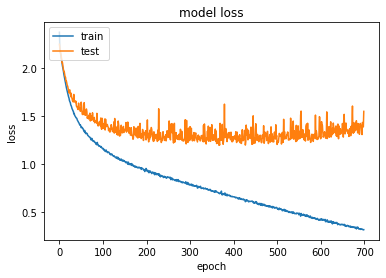

In [96]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [97]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\jupyter lab\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [98]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [99]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 52.20%


## Predicting emotions on the test data

In [100]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

6/6 [==============================] - 0s 14ms/step


In [101]:
preds

array([[1.3157953e-07, 4.2527967e-11, 2.2501737e-10, ..., 3.6586367e-03,
        1.4990177e-04, 6.5156943e-05],
       [2.2288890e-05, 5.2491137e-05, 7.7698223e-07, ..., 6.4054050e-02,
        6.6231865e-01, 8.6363152e-02],
       [7.6505625e-05, 9.7259921e-01, 2.6193346e-04, ..., 1.1437494e-13,
        5.2883468e-11, 6.3244363e-07],
       ...,
       [2.0313162e-06, 4.0729393e-09, 5.9685847e-09, ..., 8.9264503e-03,
        8.9601147e-01, 1.7780482e-03],
       [2.4912677e-06, 3.0999420e-06, 4.3332467e-09, ..., 7.2525763e-03,
        1.9937721e-01, 4.8193317e-02],
       [1.7357810e-07, 1.3445417e-10, 1.2522072e-07, ..., 3.6663774e-01,
        5.7582653e-01, 4.7488178e-05]], dtype=float32)

In [102]:
preds1=preds.argmax(axis=1)

In [103]:
preds1

array([5, 8, 1, 1, 1, 1, 1, 5, 9, 8, 8, 6, 1, 1, 8, 2, 5, 4, 1, 1, 0, 0,
       8, 2, 5, 1, 1, 1, 5, 2, 5, 6, 3, 3, 1, 9, 6, 2, 6, 8, 5, 7, 5, 2,
       1, 8, 8, 8, 7, 1, 5, 3, 3, 7, 2, 2, 8, 1, 7, 2, 9, 1, 2, 2, 7, 5,
       7, 3, 0, 5, 6, 2, 9, 5, 1, 2, 2, 2, 8, 1, 1, 5, 8, 9, 5, 6, 2, 8,
       1, 9, 8, 7, 8, 1, 1, 8, 6, 3, 8, 6, 8, 3, 1, 5, 5, 9, 1, 7, 6, 9,
       9, 8, 3, 2, 1, 1, 2, 3, 6, 1, 6, 6, 3, 1, 1, 5, 7, 0, 9, 5, 2, 5,
       9, 1, 8, 1, 4, 2, 3, 6, 8, 2, 9, 6, 1, 5, 6, 5, 8, 0, 6, 8, 2, 2,
       9, 1, 9, 8, 3, 2, 2, 5, 8, 8, 1, 2, 6, 2, 6, 3, 7, 8, 8, 7, 7, 5,
       4, 0, 5, 8, 6, 8], dtype=int64)

In [104]:
abc = preds1.astype(int).flatten()

In [105]:
predictions = (lb.inverse_transform((abc)))

In [106]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_angry
1,male_happy
2,female_calm
3,female_calm
4,female_calm
5,female_calm
6,female_calm
7,male_angry
8,male_sad
9,male_happy


In [107]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [108]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,male_angry
2,female_calm
3,female_happy
4,female_calm
5,female_calm
6,female_sad
7,male_calm
8,male_calm
9,male_fearful


In [109]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [110]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_fearful,male_fearful
171,male_fearful,male_happy
172,male_happy,male_happy
173,male_fearful,male_fearful
174,male_calm,male_fearful
175,male_angry,male_angry
176,female_sad,female_sad
177,female_angry,female_angry
178,male_fearful,male_angry
179,male_happy,male_happy


In [111]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,13
female_calm,16
female_fearful,15
female_happy,18
female_sad,20
male_angry,23
male_calm,18
male_fearful,20
male_happy,19


In [112]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,6
female_calm,35
female_fearful,26
female_happy,13
female_sad,3
male_angry,24
male_calm,19
male_fearful,12
male_happy,30


In [113]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [114]:
data, sampling_rate = librosa.load('output10.wav')

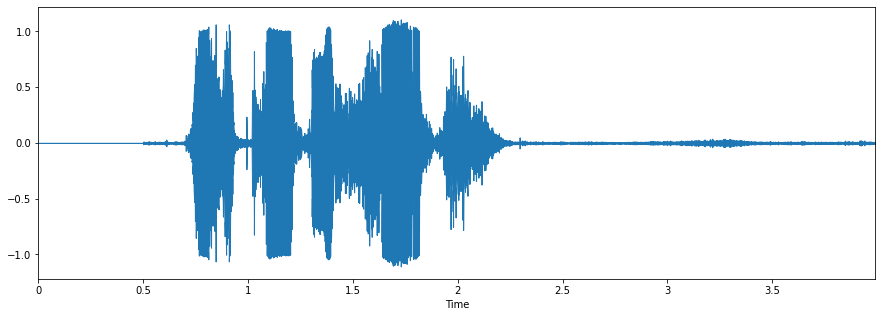

In [116]:

import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [117]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [118]:
livedf2= pd.DataFrame(data=livedf2)

In [119]:
livedf2 = livedf2.stack().to_frame().T

In [120]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203562,-21.471832,-22.522209,-21.712259,-22.264282,-20.707907,-21.72644,-21.76865,-24.302736,-22.250633,...,-24.273817,-24.63994,-24.929155,-24.439188,-25.210173,-24.740648,-22.311916,-22.579805,-22.314659,-21.552433


In [121]:
twodim= np.expand_dims(livedf2, axis=2)

In [122]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 16ms/step


In [123]:
livepreds

array([[8.89674187e-01, 6.91748481e-09, 1.09170936e-01, 9.35559627e-04,
        6.57707787e-05, 1.36646573e-04, 7.67415571e-08, 2.13282556e-06,
        1.46083066e-05, 1.92262406e-09]], dtype=float32)

In [124]:
livepreds1=livepreds.argmax(axis=1)

In [125]:
liveabc = livepreds1.astype(int).flatten()

In [126]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['female_angry'], dtype=object)